# Setup

## Libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Exploratory data analysis
import sidetable
from pandas_profiling import ProfileReport

from itertools import combinations, permutations


# Statistical packages ### & ML packages
import phik
import prince
from scipy import stats

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches, colors
from adjustText import adjust_text

# Widget interaction
from ipywidgets import interact

## Library settings

In [2]:
# see rc Params on https://matplotlib.org/stable/tutorials/introductory/customizing.html
# or just take a look at plt.rcParams
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.6,
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.labelpad': 20,
        'axes.titlepad': 30
    }
)

## Custom functions

In [3]:
## -- Observed-expected plots -- ##

def bootstrap_chi2(df, cat_col1, cat_col2, expected=False, n_boostrap=1_000, ci=.95):
    ci_lower = np.round((1-ci)/2, 3)
    ci_upper = 1 - ci_lower
    
    bootstrap_values = []
    for i in range(n_boostrap):
        df_sample = df.sample(frac=1, replace=True)
        df_sample_crosstab = pd.crosstab(df_sample[cat_col1], df_sample[cat_col2])
        if expected:
            bootstrap_values.append(stats.chi2_contingency(df_sample_crosstab)[-1])
        else:
            bootstrap_values.append(df_sample_crosstab)
    
    bootstrap_values_pct = [boostrap_sample / boostrap_sample.sum() for boostrap_sample in bootstrap_values]
    
    ci_array = np.quantile(a=np.array(bootstrap_values), q=[ci_lower,ci_upper], axis=0).round().astype(int)
    ci_array_pct = np.quantile(a=np.array(bootstrap_values_pct), q=[ci_lower,ci_upper], axis=0).round(2)
    
    return ci_array, ci_array_pct


def make_heatmap_freqlabel(df, index, columns, expected=False, bootstrap=False, **kwargs):
    df_crosstab = pd.crosstab(df[index], df[columns])
    
    if expected:
        df_crosstab = (
            pd.DataFrame(stats.chi2_contingency(df_crosstab)[-1], index=df_crosstab.index, columns=df_crosstab.columns)
            .round().astype(int)
        )
    
    df_crosstab_str = df_crosstab.astype(str)
    df_crosstab_str_pct = (df_crosstab / df_crosstab.sum().sum()*100).round().astype(int).astype(str)+'%'
    
    if bootstrap:
        ci = bootstrap_chi2(df, index, columns, expected, **kwargs)
        df_crosstab_str = df_crosstab_str + '\n(' + ci[0][0].astype(str) + ' - ' + ci[0][1].astype(str) + ')'
        
        ci_lower_pct = (ci[1][0]*100).astype(int).astype(str)
        ci_upper_pct = (ci[1][1]*100).astype(int).astype(str)
        df_crosstab_str_pct = df_crosstab_str_pct + '\n(' + ci_lower_pct + '% - ' + ci_upper_pct + '%)'
        
    return df_crosstab_str + '\n\n' + df_crosstab_str_pct


## -- Cramer's V -- ##

def calculate_cramerV(df, index, columns):
    df_crosstab = pd.crosstab(df[index], df[columns]).values
    X2 = stats.chi2_contingency(df_crosstab, correction=False)[0]
    minimum_dimension = min(df_crosstab.shape)-1
    N = np.sum(df_crosstab)
    result = np.sqrt(X2 / (N*minimum_dimension))
    return result


## -- Entropy Functions-- ##

def calculate_entropy(array):
    norm_counts = pd.Series(array).value_counts(normalize=True)
    norm_counts *= np.log2(norm_counts)
    return -np.sum(norm_counts)


def information_gain(df, target_col, split_col):
    parent_entropy = calculate_entropy(df[target_col])
    child_proportions = df[split_col].value_counts(normalize=True)
    child_weighted_entropies = np.sum([pct*df.query(f"{split_col}==@category")[target_col].pipe(calculate_entropy) for category,pct in child_proportions.iteritems()])
    information_gain = parent_entropy - child_weighted_entropies
    return parent_entropy, child_weighted_entropies, information_gain


def calculate_child_entropies(df, target_col, split_col):
    child_proportions = df[split_col].value_counts(normalize=True)
    child_entropies = {
        category: (
            proportion,
            df.query(f"{split_col}==@category")[target_col].pipe(calculate_entropy)
        )
        for category,proportion in child_proportions.iteritems()
    }
    
    df_child_entropies = (
        pd.DataFrame(child_entropies, index=['proportion','entropy'])
        .transpose()
        .sort_values('proportion')
        .assign(cumulative_proportion = lambda x: x.proportion.cumsum())
    )

    return df_child_entropies


def plot_child_entropy(e, ax=None):
    if ax is None:
        fig,ax = plt.subplots(figsize=(11,8))

    for i in range(e.shape[0]):
        x0 = 0 if i==0 else e.iloc[i-1, e.columns.get_loc('cumulative_proportion')]
        x1 = e.iloc[i, e.columns.get_loc('cumulative_proportion')]
        y0 = 0
        y1 = e.iloc[i, e.columns.get_loc('entropy')]
        center_x = (x0+x1) / 2
        center_y = (y0+y1) / 2
        first_letter_annotation = str(e.index[i])[0]

        rect = patches.Rectangle(xy=(x0,y0), width=x1-x0, height=y1, hatch='/', edgecolor='gray', facecolor=colors.to_rgba('gray', 0.1), lw=2)
        ax.add_patch(rect)

        ax.annotate(first_letter_annotation, (center_x, center_y), weight='bold', ha='center', va='center')
        ax.plot(center_x, center_y, 'o', ms=30, mfc='white', color='black', linewidth=4)
        ax.set(xlim=(0,1),ylim=(0,1), xlabel='Proporção', ylabel='Entropia')
        ax.set_yticks(np.arange(2,12, 2)/10)
        ax.tick_params(left=False, bottom=False)
        ax.grid(True, ls='--', alpha=.3, color='black')
        
    return ax


def plot_parent_entropy(e, ax=None):
    if ax is None:
        fig,ax = plt.subplots(figsize=(11,8))

    rect = patches.Rectangle(xy=(0,0), width=1, height=e, hatch='/', edgecolor='gray', facecolor=colors.to_rgba('gray', 0.1), lw=2)
    ax.add_patch(rect)

    ax.set(xlim=(0,1),ylim=(0,1), xlabel='Proporção', ylabel='Entropia')
    ax.set_yticks(np.arange(2,12, 2)/10)
    ax.tick_params(left=False, bottom=False)
    ax.grid(True, ls='--', alpha=.3, color='black')

    return ax

## Load dataset

The Telco customer churn data contains information about a fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3.  
It indicates which customers have left, stayed, or signed up for their service.

Downladed from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [4]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID')

In [5]:
print('Dataframe has {} rows and {} columns.\n'.format(*df.shape))
display(df.head())

Dataframe has 7043 rows and 20 columns.



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

In [7]:
numerical_columns = ['tenure','MonthlyCharges','TotalCharges']
categorical_columns = df.columns[~df.columns.isin(numerical_columns)].tolist()

df[categorical_columns] = df[categorical_columns].astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   category
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod 

# MAIN

## EDA

In [9]:
df.stb.freq(['Churn'])

,Churn,count,percent,cumulative_count,cumulative_percent
0,No,5174,73.463013,5174,73.463013
1,Yes,1869,26.536987,7043,100.000000


In [10]:
df.profile_report(interactions=None)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
target_col = categorical_columns.pop(categorical_columns.index('Churn'))

## Chi2

### Chi-squared test

$$\chi^2 = \sum_i{\frac{(O_i-E_i)^2}{E_i}}$$

#### Observed frequencies

In [12]:
index = 'PaperlessBilling'
columns = 'Churn'

df_crosstab = pd.crosstab(df[index], df[columns])
df_crosstab

Churn,No,Yes
PaperlessBilling,,
No,2403,469
Yes,2771,1400


#### Expected frequencies

In [13]:
stats.chi2_contingency(df_crosstab)

(258.27764906707307,
 4.073354668665985e-58,
 1,
 array([[2109.85773108,  762.14226892],
        [3064.14226892, 1106.85773108]]))

In [14]:
pd.DataFrame(
    data=stats.chi2_contingency(df_crosstab)[-1],
    index=df_crosstab.index,
    columns=df_crosstab.columns
)

Churn,No,Yes
PaperlessBilling,,
No,2109.857731,762.142269
Yes,3064.142269,1106.857731


Exemplo de quando os valores observados são iguais aos esperados:

In [15]:
df_crosstab = pd.DataFrame(
    np.array([100]*4).reshape((2,2))
)

df_crosstab

,0,1
0,100,100
1,100,100


In [16]:
stats.chi2_contingency(df_crosstab)

(0.0,
 1.0,
 1,
 array([[100., 100.],
        [100., 100.]]))

#### Teste qui-quadrado

Aplicar teste para todas variáveis categóricas do dataset:

In [17]:
df_styled = (
    pd.DataFrame(
        {cat_col: stats.chi2_contingency(pd.crosstab(df[cat_col], df.Churn), correction=True)[:2] for cat_col in categorical_columns},
        index=['chi2','pvalue']
    )
    .transpose()
    .sort_values('chi2', ascending=False)
    .style.background_gradient(cmap='Oranges')
    
)

display(df_styled)

,chi2,pvalue
Contract,1184.596572,0.000000
OnlineSecurity,849.998968,0.000000
TechSupport,828.197068,0.000000
InternetService,732.309590,0.000000
PaymentMethod,648.142327,0.000000
OnlineBackup,601.812790,0.000000
DeviceProtection,558.419369,0.000000
StreamingMovies,375.661479,0.000000
StreamingTV,374.203943,0.000000
PaperlessBilling,258.277649,0.000000


#### Observed vs Expected heatmap

In [18]:
@interact(index=categorical_columns, columns=['Churn'])
def plot_heatmap(index, columns, bootstrap=False):
    df_absfreq = pd.crosstab(df[index], df[columns])
    df_absfreq_expected = pd.DataFrame(stats.chi2_contingency(df_absfreq)[-1], index=df_absfreq.index, columns=df_absfreq.columns).round().astype(int)

    plot_title = f'{index} vs {columns}'
    fig, ax = plt.subplots(ncols=2, figsize=(12,6))

    ax1 = sns.heatmap(df_absfreq, cmap='Blues', annot=make_heatmap_freqlabel(df, index, columns), fmt='', cbar=False, ax=ax[0],linewidths=.5)
    ax1.text(x=0.5, y=1.1, s=plot_title, fontsize='large', weight='bold', ha='center', va='bottom', transform=ax1.transAxes)
    ax1.text(x=0.5, y=1.04, s='Observed values', fontsize='small', alpha=0.75, ha='center', va='bottom', transform=ax1.transAxes)
    ax1.tick_params(left=False)

    ax2 = sns.heatmap(df_absfreq_expected, cmap='Blues', annot=make_heatmap_freqlabel(df, index, columns, bootstrap=bootstrap, expected=True), cbar=False, fmt='', ax=ax[1], linewidths=.5)
    ax2.text(x=0.5, y=1.1, s=plot_title, fontsize='large', weight='bold', ha='center', va='bottom', transform=ax2.transAxes)
    ax2.text(x=0.5, y=1.04, s='Expected values under independent-association hypothesis', fontsize='small', alpha=0.75, ha='center', va='bottom', transform=ax2.transAxes)
    ax2.tick_params(left=False)
    ax2.set_ylabel(None)
    ax2.set_yticks([])

    plt.tight_layout(w_pad=3)
    plt.show()

interactive(children=(Dropdown(description='index', options=('gender', 'SeniorCitizen', 'Partner', 'Dependents…

#### Chi-squared distribution

In [19]:
@interact(index=categorical_columns, columns=['Churn'])
def plot_chi2(index, columns):
    # Get observed chi2 and dof
    chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(df[index], df[columns]))
    # Get theoretical chi2 distribution
    theorical_chi2_dist = np.random.chisquare(dof, df.shape[0])

    # Plot
    plt.figure(figsize=(9,6))
    ax = sns.histplot(theorical_chi2_dist, kde=True, color='orange', alpha=.3, stat='density')
    ax.axvline(chi2, ls='--', color='black', ymax=.9, label=f'$\chi^2$ = {chi2:.2f}')
    plt.legend(loc='upper right', prop={'size':'small'}, frameon=False)
    
    ax.set_title(f'Theoretical $\chi^2$ distribution for {index} vs {columns}', y=1.05, weight='bold', size=14)
    ax.annotate(f'P(X > {chi2:.2f}) = {1-stats.chi2.cdf(chi2, dof):.4f}', xy=(.5,1.06), xycoords='axes fraction', ha='center')
    
    sns.despine(offset=10, trim=True, ax=ax)
    plt.show()

interactive(children=(Dropdown(description='index', options=('gender', 'SeniorCitizen', 'Partner', 'Dependents…

## Cramer's V

Fórmula:

$$
\text{Cramer's V} = \sqrt{\frac{\chi^2}{N(k-1)}}
$$

onde:  
$N$: soma dos valores da tabela de contingência  
$k$ = valor mínimo de dimensão (quantidade de linhas vs quantidade de colunas)

In [20]:
df_cramer = pd.DataFrame([(var1, var2, calculate_cramerV(df, var1, var2)) for var1,var2 in permutations(categorical_columns+['Churn'], r=2)], columns=['var1','var2','cramerV'])
df_cramer = df_cramer.pivot(index='var1', columns='var2', values='cramerV')
df_cramer

var2,Churn,Contract,Dependents,DeviceProtection,InternetService,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PaymentMethod,PhoneService,SeniorCitizen,StreamingMovies,StreamingTV,TechSupport,gender
var1,,,,,,,,,,,,,,,,,
Churn,NaN,0.410116,0.164221,0.281580,0.322455,0.040109,0.292316,0.347400,0.191825,0.150448,0.303359,0.011942,0.150889,0.230951,0.230502,0.342916,0.008612
Contract,0.410116,NaN,0.244212,0.296976,0.206921,0.080408,0.258572,0.301349,0.177645,0.296039,0.266655,0.003976,0.143868,0.238640,0.235901,0.331021,0.008153
Dependents,0.164221,0.244212,NaN,0.157570,0.180267,0.025094,0.162760,0.194579,0.111377,0.452676,0.150744,0.001762,0.211185,0.141335,0.147082,0.182377,0.010517
DeviceProtection,0.281580,0.296976,0.157570,NaN,0.707108,0.246342,0.719125,0.717291,0.321631,0.166568,0.287021,0.172317,0.183071,0.736047,0.733661,0.726485,0.006029
InternetService,0.322455,0.206921,0.180267,0.707108,NaN,0.396726,0.707184,0.724466,0.378427,0.000907,0.313123,0.452425,0.265324,0.716008,0.717099,0.722904,0.011320
MultipleLines,0.040109,0.080408,0.025094,0.246342,0.396726,NaN,0.245163,0.229608,0.166341,0.143898,0.166930,1.000000,0.146643,0.262356,0.261791,0.230162,0.009452
OnlineBackup,0.292316,0.258572,0.162760,0.719125,0.707184,0.245163,NaN,0.718434,0.321046,0.153337,0.282517,0.172818,0.182774,0.713682,0.714699,0.719834,0.013798
OnlineSecurity,0.347400,0.301349,0.194579,0.717291,0.724466,0.229608,0.718434,NaN,0.341800,0.152010,0.304959,0.176272,0.211070,0.708208,0.707788,0.733071,0.017025
PaperlessBilling,0.191825,0.177645,0.111377,0.321631,0.378427,0.166341,0.321046,0.341800,NaN,0.014877,0.248719,0.016505,0.156530,0.332111,0.336061,0.329524,0.011754


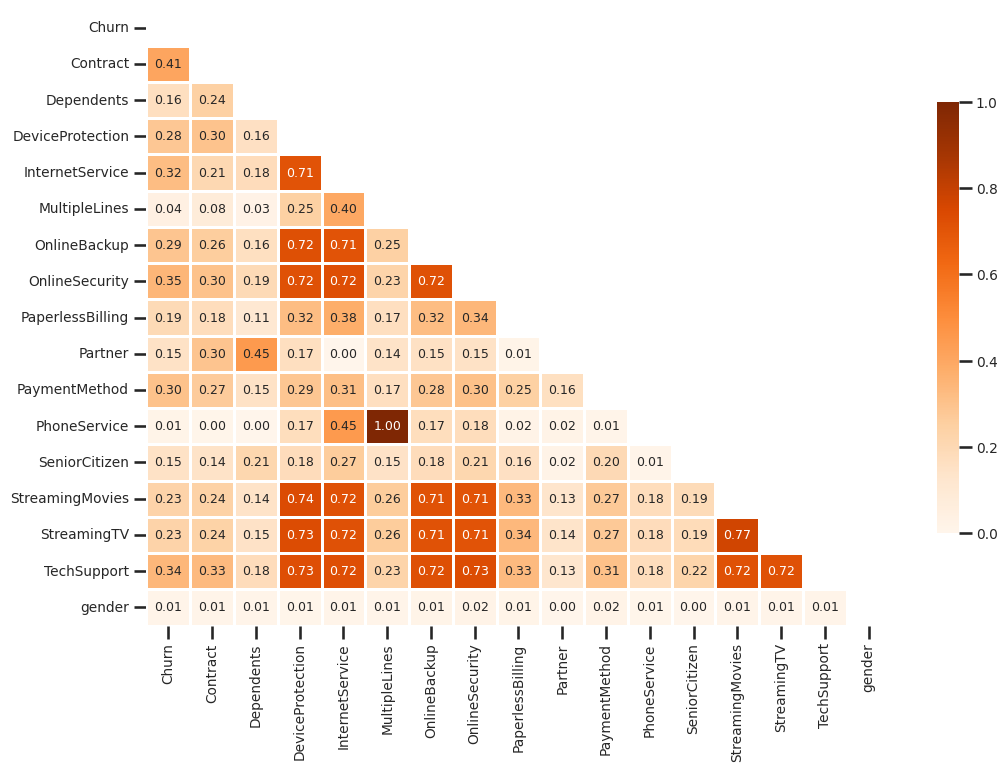

In [21]:
fig,ax = plt.subplots(figsize=(12,8))

mask = np.zeros(df_cramer.shape).astype(bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_cramer, cmap='Oranges', mask=mask, square=False, vmin=0, vmax=1, linewidths=1,
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar=True, cbar_kws={'orientation':'vertical', 'shrink': .7}, ax=ax)
ax.set(xlabel=None, ylabel=None)
plt.yticks(rotation=0)
plt.show()

In [22]:
pd.crosstab(df['PhoneService'], df['MultipleLines'])

MultipleLines,No,No phone service,Yes
PhoneService,,,
No,0,682,0
Yes,3390,0,2971


## ANACOR

### Correspondence Analysis (CA)

In [23]:
@interact(cat_col1=categorical_columns+[target_col], cat_col2=categorical_columns+[target_col])
def plot_ca(cat_col1, cat_col2, ajust_labels=False):
    df_crosstab = pd.crosstab(df[cat_col1], df[cat_col2])
    ca = prince.ca.CA().fit(df_crosstab)

    ax = ca.plot_coordinates(df_crosstab, figsize=(10,6))
    # sns.despine(offset=10, trim=False)

    if ajust_labels:
        adjust_text(ax.texts)

    plt.show()

interactive(children=(Dropdown(description='cat_col1', options=('gender', 'SeniorCitizen', 'Partner', 'Depende…

### Multiple Correspondence Analysis (MCA)

In [24]:
X = df[categorical_columns+[target_col]]

In [25]:
mca = prince.MCA().fit(X)

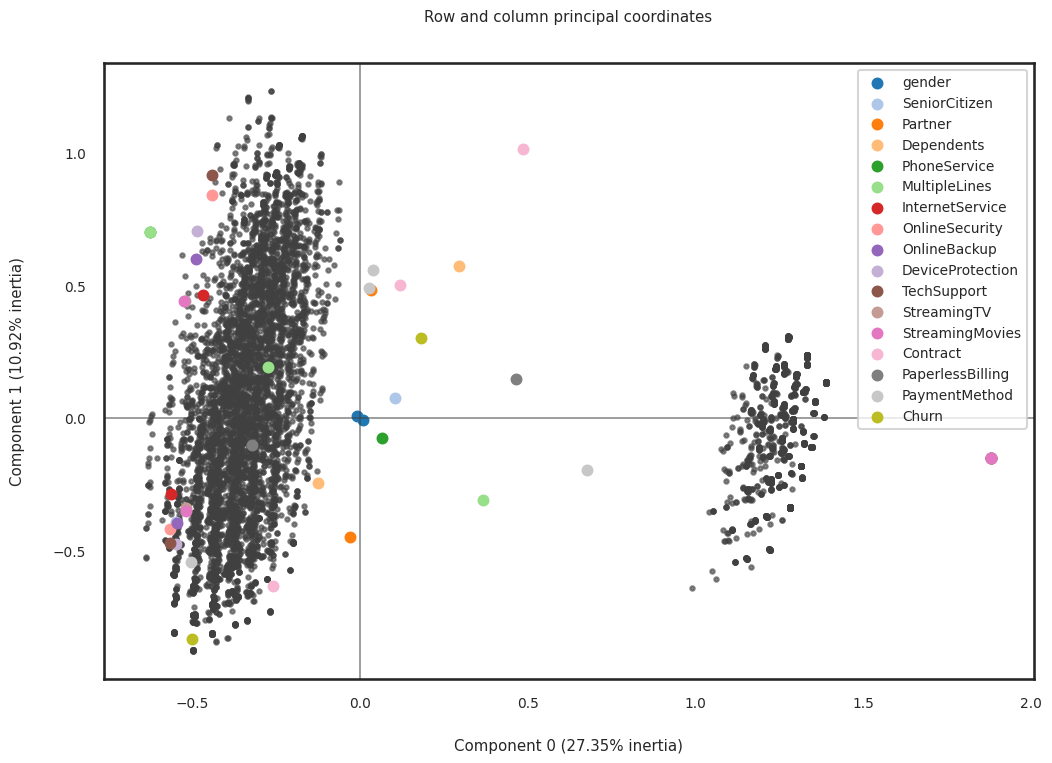

In [26]:
sns.set_palette('tab20')
ax = mca.plot_coordinates(X, figsize=(12,8), column_points_size=50, show_column_labels=False)
# adjust_text(ax.texts)
plt.show()

## Entropy

### Entropy calculation

$$
Entropy = - \sum_{i=1}^{k}{\ p_i\ log_2(p_i)}
$$

onde $p$ é a proporção de observações para a categoria $i$

Fórmula do ganho de informação (*information gain - IG*)

$$
IG = E(P) - \sum_{i=1}{p(C)_i E(C)_i}
$$

### Entropy visualization

In [27]:
@interact(target_col=['Churn'], split_col=categorical_columns)
def plot_entropies(target_col, split_col):
    
    e_children = calculate_child_entropies(df, target_col, split_col)
    e_parent, e_children_weighted, ig = information_gain(df, target_col, split_col)

    fig, axes = plt.subplots(ncols=2, figsize=(14,6), gridspec_kw={'width_ratios':[.5,.6]})

    plot_parent_entropy(e_parent, ax=axes[0])
    plot_child_entropy(e_children, ax=axes[1])

    axes[0].set_title(f'Entropia padrão para {target_col}', size='large', y=1.05)
    axes[0].annotate(f'Parent entropy: {e_parent:.2f}', xy=(.5,1.06), xycoords='axes fraction', ha='center', c='gray')

    axes[1].set_title(f'Entropia e prevalência de valores para {split_col}', size='large', y=1.05)
    axes[1].annotate(f'Weighted children entropy = {e_children_weighted:.2f} | Information gain = {ig:.2f}', xy=(.5,1.06), xycoords='axes fraction', ha='center', c='gray')

    plt.tight_layout(w_pad=3)
    plt.show()

interactive(children=(Dropdown(description='target_col', options=('Churn',), value='Churn'), Dropdown(descript…

### Tree-based model to assess correspondence among categorical variables

In [28]:
import graphviz
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [29]:
X,y = pd.get_dummies(df[categorical_columns]), df[target_col]

In [30]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3).fit(X,y)

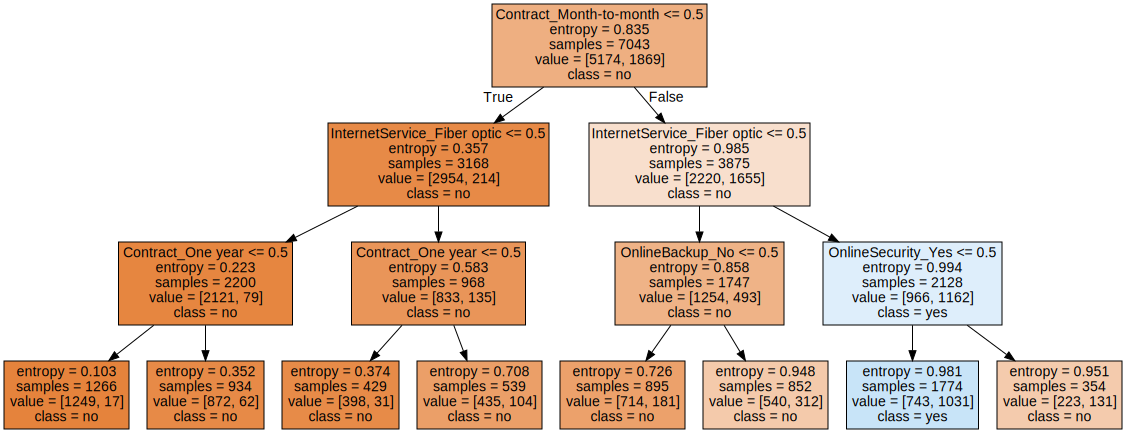

In [31]:
# Get dot data
dot_data = tree.export_graphviz(
    decision_tree=dt,
    out_file=None, 
    feature_names=dt.feature_names_in_,  
    class_names=['no','yes'],
    filled=True
)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph